# Group 3: <br>
Avedis Sarkisian, DePaul University, School of Computing, asarkis5@depaul.edu <br>
Faizan Bhutto, DePaul University, School of Computing, fbhutto@depaul.edu <br>
Gael Mota Hernandez, DePaul University, School of Computing, gmotaher@depaul.edu <br>
Huzifa Noor, DePaul University, School of Computing, hnoor2@depaul.edu

# **XGBoost to predict Healthcare Costs**

Import and Load Libraries

In [ ]:
!pip install xgboost lightgbm tabulate

import numpy as np
import pandas as pd

import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Files

In [ ]:
# Define the correct folder path
base_path = "/content/drive/MyDrive/Capstone Project/Data/"

# Load feature datasets
X_train = pd.read_csv(base_path + "features_train.csv")
X_test = pd.read_csv(base_path + "features_test.csv")

# Load cost datasets (y values) and flatten them
y_train = pd.read_csv(base_path + "cost_train.csv").values.ravel()
y_test = pd.read_csv(base_path + "cost_test.csv").values.ravel()

# Verify dataset shape
print(f"Training Features: {X_train.shape}, Training Labels: {y_train.shape}")
print(f"Test Features: {X_test.shape}, Test Labels: {y_test.shape}")

Training Features: (1492974, 138), Training Labels: (1492974,)
Test Features: (639847, 138), Test Labels: (639847,)


In [ ]:
# Convert DataFrames to DMatrix (optimized for XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

Train XGBoost

In [ ]:
# XGBoost parameters (adjust these as needed)
params = {
    'objective': 'reg:squarederror',  # regression task
    'eval_metric': 'rmse',            # rmse
    'tree_method': 'hist',
    'device': 'cuda',
    'learning_rate': 0.05,            # step size shrinkage
    'max_depth': 10,                  #prevent overfitting
}

In [ ]:
xgb_model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, "Test")], early_stopping_rounds=50, verbose_eval=False)

In [ ]:
# Make predictions
y_pred = xgb_model.predict(dtest)
y_test = y_test.ravel()

In [ ]:
# Calculate MSE, RMSE, and R_SQUARED
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"XGBoost Model Performance:")
print(tabulate([
    ["MSE", f"{mse:.2f}"],
    ["RMSE", f"{rmse:.2f}"],
    ["R²", f"{r2:.4f}"]],
    headers=["Metric", "Value"],
    tablefmt="rounded_outline"))

Feature Selection

In [ ]:
# Extract feature importance from XGBoost model
feature_importance = xgb_model.get_score(importance_type='weight')
feature_importance_df = pd.DataFrame({
    'Feature': list(feature_importance.keys()),
    'Importance': list(feature_importance.values())
})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

In [ ]:
importance_thresholds = [0.98, 0.95, 0.90]
results = {}
for threshold in importance_thresholds:
  feature_importance_df['cumulative_importance'] = feature_importance_df['Importance'].cumsum() / feature_importance_df['Importance'].sum()
  selected_features = feature_importance_df[feature_importance_df['cumulative_importance'] <= threshold]['Feature'].tolist()
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]

  dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train)
  dtest_selected = xgb.DMatrix(X_test_selected, label=y_test)

  xgb_model_selected = xgb.train(
      params,
      dtrain_selected,
      num_boost_round=500,
      evals=[(dtest_selected, "Test")],
      early_stopping_rounds=50,
      verbose_eval=False
  )

  # Make predictions
  dtest_selected = xgb.DMatrix(X_test_selected, label=y_test)
  y_pred_selected = xgb_model_selected.predict(dtest_selected)

  # Calculate Metrics
  mse = mean_squared_error(y_test, y_pred_selected)
  rmse = np.sqrt(mse)
  r2_score_value = r2_score(y_test, y_pred_selected)

  # Store results
  results[threshold] = {
      'n_features': len(selected_features),
      'mse': mse,
      'rmse': rmse,
      'r2_score': r2_score_value,
      'features': selected_features
  }

In [ ]:
# Print results
for threshold, metrics in results.items():
  print(tabulate([
      [f"Threshold: {threshold}"],
      [f"Number of Features: {metrics['n_features']}"],
      [f"MSE: {metrics['mse']:.2f}"],
      [f"RMSE: {metrics['rmse']:.2f}"],
      [f"R² Score: {metrics['r2_score']:.4f}"]],
      headers=["Metric", "Value"],
      tablefmt="rounded_outline"))

╭─────────────────────────╮
│ Metric                  │
├─────────────────────────┤
│ Threshold: 0.98         │
│ Number of Features: 129 │
│ MSE: 0.18               │
│ RMSE: 0.42              │
│ R² Score: 0.8192        │
╰─────────────────────────╯
╭─────────────────────────╮
│ Metric                  │
├─────────────────────────┤
│ Threshold: 0.95         │
│ Number of Features: 120 │
│ MSE: 0.18               │
│ RMSE: 0.43              │
│ R² Score: 0.8192        │
╰─────────────────────────╯
╭─────────────────────────╮
│ Metric                  │
├─────────────────────────┤
│ Threshold: 0.9          │
│ Number of Features: 106 │
│ MSE: 0.18               │
│ RMSE: 0.42              │
│ R² Score: 0.8193        │
╰─────────────────────────╯


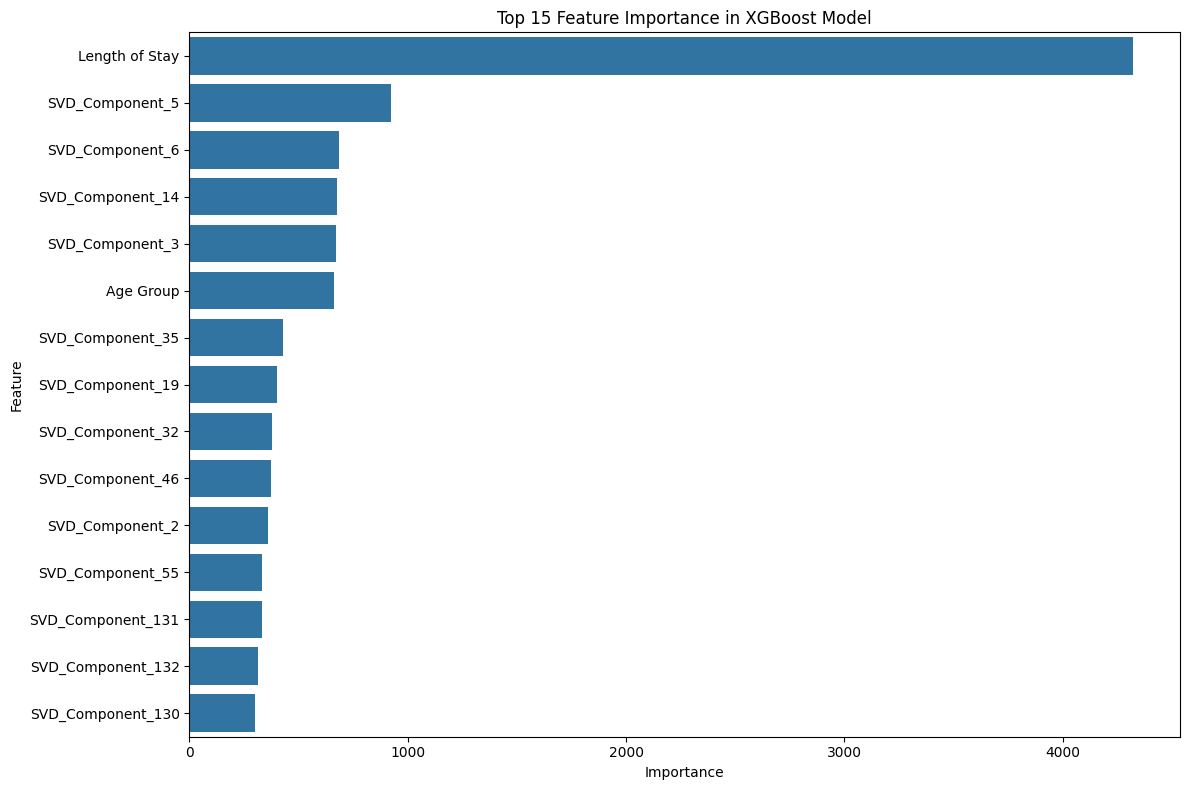

In [ ]:
# Plot feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance_df.head(15)  # Get top 15 features
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 15 Feature Importance in XGBoost Model')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()
plt.show()

Evaluation

**MSE	0.18** -	On average, predictions are off by $0.18 (scaled).

**RMSE	0.42** - The typical error in predictions is $0.42 (scaled), considering larger errors more heavily.

**R² Score  0.8193**	- 	The model explains ~81.93% of the variance in healthcare costs.

Save Model

In [ ]:
drive_path = "/content/drive/My Drive/Capstone Project/Code/Models/XGBoost/xgb_model.joblib"
joblib.dump(xgb_model, drive_path)
print(f"Model saved to Google Drive: {drive_path}")

Model saved to Google Drive: /content/drive/My Drive/Capstone Project/Code/Models/XGBoost/xgb_model.joblib
